In [1]:
import HomologyBasis as HB
from divisivegater.simplex_tree import SimplexTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from itertools import combinations
import time

In [2]:
filename = 'dragon_vrips_2000.txt'
data = np.loadtxt('data/benchmarks/dragon_vrip.ply.txt_2000_.txt')

def persistence_check(pairs1,pairs2):
    for i in pairs1:
        for pair in pairs1[i]:
            if pair not in pairs2[i]:
                return False
    return True

In [3]:
max_dimension=2

HB_time=list()
ST_time=list()
iterations=list()

for n in range(100,301,5):
    X=list([list(data[i]) for i in range(0,n)])
    maximal_faces=[list(sigma) for sigma in combinations(range(0,len(X)),max_dimension+1)]

    simplicial_complex = HB.simplicial_complex_from_maximal_faces(
        maximal_faces=maximal_faces, 
        max_dimension=max_dimension)

    filt_fct = HB.dictionary_filtration_function(
        simplicial_complex=simplicial_complex,
        filtration_value_function=HB.rips_filtration_function(X))

    degreewise_ordered_simplicial_complex = HB.degreewise_ordered_complex(simplicial_complex, filt_fct)

    start_HB=time.time()
    phom = HB.filtered_homology_basis(degreewise_ordered_simplicial_complex, 
                                max_face_card=max_dimension + 1, 
                                coeff_field=11)
    persistent_homology_pairs = HB.persistence_pairs(
        homology_basis=phom,
        filtration_function=filt_fct,
        max_dimension=max_dimension)
    total_HB=(time.time()-start_HB)
    
    start_ST=time.time()
    st = SimplexTree()
    for simplices in simplicial_complex:
        for face in simplices:
            st.insert(face, filt_fct(face))        
    persistent_homology_pairs_st = {index: pairs for index, pairs in enumerate(st.persistent_homology(coeff_field=11))}
    total_ST=(time.time()-start_ST)

    if persistence_check(persistent_homology_pairs_st,persistent_homology_pairs)==False:
        print('Fail')
        break

    HB_time.append(total_HB)
    ST_time.append(total_ST)
    iterations.append(n)

In [4]:
proportion=np.array(HB_time)/np.array(ST_time)

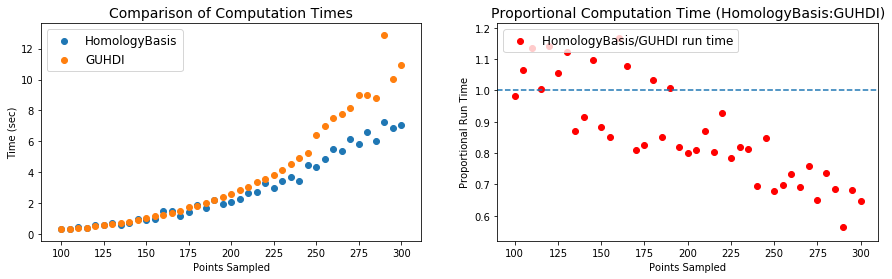

In [5]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
ax1.scatter(iterations,HB_time,label='HomologyBasis')
ax1.scatter(iterations,ST_time,label='GUHDI')
ax1.set_ylabel('Time (sec)')
ax1.set_xlabel('Points Sampled')
ax1.set_title('Comparison of Computation Times',fontsize=14)
ax1.legend(loc='upper left',fontsize=12)

ax2.scatter(iterations,proportion,color='red',label='HomologyBasis/GUHDI run time')
ax2.axhline(y=1,linestyle='--')
ax2.set_ylabel('Proportional Run Time')
ax2.set_xlabel('Points Sampled')
ax2.set_title('Proportional Computation Time (HomologyBasis:GUHDI)',fontsize=14)
ax2.legend(loc='upper left',fontsize=12)